# Drug Molecule Generation with VAE

**Description:** Implementing a Convolutional Variational AutoEncoder (VAE) for Drug Discovery.

## Introduction

In this example, we use a Variational Autoencoder to generate molecules for drug discovery.
We use the research papers
[Automatic chemical design using a data-driven continuous representation of molecules](https://arxiv.org/abs/1610.02415)
and [MolGAN: An implicit generative model for small molecular graphs](https://arxiv.org/abs/1805.11973)
as a reference.

The model described in the paper **Automatic chemical design using a data-driven
continuous representation of molecules** generates new molecules via efficient exploration
of open-ended spaces of chemical compounds. The model consists of
three components: Encoder, Decoder and Predictor. The Encoder converts the discrete
representation of a molecule into a real-valued continuous vector, and the Decoder
converts these continuous vectors back to discrete molecule representations. The
Predictor estimates chemical properties from the latent continuous vector representation
of the molecule. Continuous representations allow the use of gradient-based
optimization to efficiently guide the search for optimized functional compounds.

![intro](https://bit.ly/3CtPMzM)

**Figure (a)** - A diagram of the autoencoder used for molecule design, including the
joint property prediction model. Starting from a discrete molecule representation, such
as a SMILES string, the encoder network converts each molecule into a vector in the
latent space, which is effectively a continuous molecule representation. Given a point
in the latent space, the decoder network produces a corresponding SMILES string. A
multilayer perceptron network estimates the value of target properties associated with
each molecule.

**Figure (b)** - Gradient-based optimization in continuous latent space. After training a
surrogate model `f(z)` to predict the properties of molecules based on their latent
representation `z`, we can optimize `f(z)` with respect to `z` to find new latent
representations expected to match specific desired properties. These new latent
representations can then be decoded into SMILES strings, at which point their properties
can be tested empirically.

For an explanation and implementation of MolGAN, please refer to the Keras Example
[**WGAN-GP with R-GCN for the generation of small molecular graphs**](https://bit.ly/3pU6zXK) by
Alexander Kensert. Many of the functions used in the present example are from the above Keras example.

## Setup

RDKit is an open source toolkit for cheminformatics and machine learning. This toolkit come in handy
if one is into drug discovery domain. In this example, RDKit is used to conveniently
and efficiently transform SMILES to molecule objects, and then from those obtain sets of atoms
and bonds.


SMILES expresses the structure of a given molecule in the form of an ASCII string.
The SMILES string is a compact encoding which, for smaller molecules, is relatively human-readable.
Encoding molecules as a string both alleviates and facilitates database and/or web searching
of a given molecule. RDKit uses algorithms to accurately transform a given SMILES to
a molecule object, which can then be used to compute a great number of molecular properties/features.

In [ ]:
pip install rdkit==2022.9.5


In [ ]:
import pandas as pd

In [ ]:
pip install "numpy<2.0"

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import ast

import numpy as np

import tensorflow as tf
import keras
from keras import layers
from keras import ops

import matplotlib.pyplot as plt
from rdkit import Chem, RDLogger
from rdkit.Chem import BondType
from rdkit.Chem.Draw import MolsToGridImage

RDLogger.DisableLog("rdApp.*")

In [ ]:
pip install torch_geometric rdkit


In [ ]:
from torch_geometric.datasets import QM9
from rdkit import Chem
import pandas as pd

# Load QM9 dataset
dataset = QM9(root='qm9/')
smiles_list = dataset.smiles

target_index = 0  # Dipole moment
all_data = []

for i, data in enumerate(dataset):
    smiles = smiles_list[i]
    mol = Chem.MolFromSmiles(smiles)

    if mol is not None:
        dipole_moment = data.y[0][target_index].item()
        all_data.append((smiles, dipole_moment))

# Store in DataFrame
df = pd.DataFrame(all_data, columns=["SMILES", "DipoleMoment"])

# Preview
print(df.head())
print(df.tail())


              SMILES  DipoleMoment
0  [H]C([H])([H])[H]        0.0000
1       [H]N([H])[H]        1.6256
2            [H]O[H]        1.8511
3          [H]C#C[H]        0.0000
4             [H]C#N        2.8937
                                                   SMILES  DipoleMoment
129423  [H]C1([H])[C@@]23[N@H+]4[C@@]5([H])[C@]1([H])[...        1.4529
129424  [H]C1([H])[C@@]2([H])[C@@]3([H])[C@@]14O[C@]1(...        1.3774
129425  [H]C1([H])[N@@H+]2[C@@]3([H])[C@]2([H])[C@]2([...        1.2480
129426  [H]C1([H])[N@H+]2[C@@]3([H])[C@@]14C([H])([H])...        1.9576
129427  [H]C1([H])[N@H+]2[C@@]3([H])[C@@]14O[C@@]1([H]...        0.8626


In [ ]:
df["SMILES"][1110]

'[H]O[C@]1(C([H])([H])[H])C([H])([H])[C@@]1(O[H])C([H])([H])[H]'

In [ ]:
!wget https://github.com/rdkit/rdkit/raw/master/Contrib/SA_Score/fpscores.pkl.gz -O fpscores.pkl.gz


--2025-07-07 11:59:42--  https://github.com/rdkit/rdkit/raw/master/Contrib/SA_Score/fpscores.pkl.gz
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdkit/rdkit/master/Contrib/SA_Score/fpscores.pkl.gz [following]
--2025-07-07 11:59:43--  https://raw.githubusercontent.com/rdkit/rdkit/master/Contrib/SA_Score/fpscores.pkl.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3848394 (3.7M) [application/octet-stream]
Saving to: ‘fpscores.pkl.gz’

fpscores.pkl.gz     100%[===================>]   3.67M  --.-KB/s    in 0.08s   

2025-07-07 11:59:43 (46.4 MB/s) - ‘fpscores.pkl.gz’ saved [3848394/3848394]



## Dataset

We use the [**ZINC – A Free Database of Commercially Available Compounds for
Virtual Screening**](https://bit.ly/3IVBI4x) dataset. The dataset comes with molecule
formula in SMILE representation along with their respective molecular properties such as
**logP** (water–octanal partition coefficient), **SAS** (synthetic
accessibility score) and **QED** (Qualitative Estimate of Drug-likeness).

## Hyperparameters

In [ ]:
import ast
from rdkit import Chem
from rdkit.Chem.rdchem import BondType

# Clean up SMILES column
df["SMILES"] = df["SMILES"].astype(str).apply(lambda s: s.replace("\n", "").strip())

# Compute MAX_MOLSIZE (based on SMILES length)
MAX_MOLSIZE = max(df["SMILES"].str.len())

# Build charset from unique atoms
unique_atoms = set()
max_atoms = 0  # Initialize max atom count

for smi in df["SMILES"]:
    mol = Chem.MolFromSmiles(smi)
    if mol:
        atoms = mol.GetAtoms()
        max_atoms = max(max_atoms, len(atoms))  # Track maximum number of atoms
        for atom in atoms:
            unique_atoms.add(atom.GetSymbol())

# Handle multi-character atoms
SMILE_CHARSET = sorted(list(unique_atoms))

# Rebuild mappings
SMILE_to_index = {c: i for i, c in enumerate(SMILE_CHARSET)}
index_to_SMILE = {i: c for i, c in enumerate(SMILE_CHARSET)}
atom_mapping = dict(SMILE_to_index)
atom_mapping.update(index_to_SMILE)

# Bond type mapping
bond_mapping = {
    "SINGLE": 0, "DOUBLE": 1, "TRIPLE": 2, "AROMATIC": 3,
    0: BondType.SINGLE,
    1: BondType.DOUBLE,
    2: BondType.TRIPLE,
    3: BondType.AROMATIC
}

# Constants
BATCH_SIZE = 100
EPOCHS = 10
VAE_LR = 5e-4

NUM_ATOMS = max_atoms  # Dynamically determined
MAX_ATOMS = max_atoms  # Dynamically determined
MAX_SAMPLES = 129427  # Optional: limit on number of molecules to use
ATOM_DIM = len(SMILE_CHARSET) + 1
BOND_DIM = 4 + 1  # 4 bond types + 1 padding
LATENT_DIM = 435


In [ ]:
ATOM_DIM

6

In [ ]:
MAX_SAMPLES = 129427

In [ ]:
MAX_ATOMS

12

In [ ]:
SMILE_CHARSET

['C', 'F', 'H', 'N', 'O']

In [ ]:
# SMILE_CHARSET = '["C", "B", "F", "I", "H", "O", "N", "S", "P", "Cl", "Br"]'

# bond_mapping = {"SINGLE": 0, "DOUBLE": 1, "TRIPLE": 2, "AROMATIC": 3}
# bond_mapping.update(
#     {0: BondType.SINGLE, 1: BondType.DOUBLE, 2: BondType.TRIPLE, 3: BondType.AROMATIC}
# )
# SMILE_CHARSET = ast.literal_eval(SMILE_CHARSET)

# MAX_MOLSIZE = max(df["smiles"].str.len())
# SMILE_to_index = dict((c, i) for i, c in enumerate(SMILE_CHARSET))
# index_to_SMILE = dict((i, c) for i, c in enumerate(SMILE_CHARSET))
# atom_mapping = dict(SMILE_to_index)
# atom_mapping.update(index_to_SMILE)

# BATCH_SIZE = 100
# EPOCHS = 10

# VAE_LR = 5e-4
# NUM_ATOMS = 120  # Maximum number of atoms

# ATOM_DIM = len(SMILE_CHARSET)  # Number of atom types
# BOND_DIM = 4 + 1  # Number of bond types
# LATENT_DIM = 435  # Size of the latent space


def smiles_to_graph(smiles):
    # Converts SMILES to molecule object
    molecule = Chem.MolFromSmiles(smiles)

    # Initialize adjacency and feature tensor
    adjacency = np.zeros((BOND_DIM, NUM_ATOMS, NUM_ATOMS), "float32")
    features = np.zeros((NUM_ATOMS, ATOM_DIM), "float32")

    # loop over each atom in molecule
    for atom in molecule.GetAtoms():
        i = atom.GetIdx()
        atom_type = atom_mapping[atom.GetSymbol()]
        features[i] = np.eye(ATOM_DIM)[atom_type]
        # loop over one-hop neighbors
        for neighbor in atom.GetNeighbors():
            j = neighbor.GetIdx()
            bond = molecule.GetBondBetweenAtoms(i, j)
            bond_type_idx = bond_mapping[bond.GetBondType().name]
            adjacency[bond_type_idx, [i, j], [j, i]] = 1

    # Where no bond, add 1 to last channel (indicating "non-bond")
    # Notice: channels-first
    adjacency[-1, np.sum(adjacency, axis=0) == 0] = 1

    # Where no atom, add 1 to last column (indicating "non-atom")
    features[np.where(np.sum(features, axis=1) == 0)[0], -1] = 1

    return adjacency, features


def graph_to_molecule(graph):
    # Unpack graph
    adjacency, features = graph

    # RWMol is a molecule object intended to be edited
    molecule = Chem.RWMol()

    # Remove "no atoms" & atoms with no bonds
    keep_idx = np.where(
        (np.argmax(features, axis=1) != ATOM_DIM - 1)
        & (np.sum(adjacency[:-1], axis=(0, 1)) != 0)
    )[0]
    features = features[keep_idx]
    adjacency = adjacency[:, keep_idx, :][:, :, keep_idx]

    # Add atoms to molecule
    for atom_type_idx in np.argmax(features, axis=1):
        atom = Chem.Atom(atom_mapping[atom_type_idx])
        _ = molecule.AddAtom(atom)

    # Add bonds between atoms in molecule; based on the upper triangles
    # of the [symmetric] adjacency tensor
    (bonds_ij, atoms_i, atoms_j) = np.where(np.triu(adjacency) == 1)
    for bond_ij, atom_i, atom_j in zip(bonds_ij, atoms_i, atoms_j):
        if atom_i == atom_j or bond_ij == BOND_DIM - 1:
            continue
        bond_type = bond_mapping[bond_ij]
        molecule.AddBond(int(atom_i), int(atom_j), bond_type)

    # Sanitize the molecule; for more information on sanitization, see
    # https://www.rdkit.org/docs/RDKit_Book.html#molecular-sanitization
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    # Let's be strict. If sanitization fails, return None
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        return None

    return molecule


##  Generate training set

In [ ]:
adjacency_tensor, feature_tensor = [], []

for idx in range(len(df)):
    if len(adjacency_tensor) >= MAX_SAMPLES:
        break

    smiles = df.loc[idx]["SMILES"]

    try:
        adjacency, features = smiles_to_graph(smiles)

        if features.shape[0] > MAX_ATOMS:
            continue  # Skip large molecules

        # Pad to fixed size
        padded_adj = np.zeros((adjacency.shape[0], MAX_ATOMS, MAX_ATOMS), dtype=np.float32)
        padded_feat = np.zeros((MAX_ATOMS, features.shape[1]), dtype=np.float32)

        num_atoms = features.shape[0]
        padded_adj[:, :num_atoms, :num_atoms] = adjacency
        padded_feat[:num_atoms] = features

        adjacency_tensor.append(padded_adj)
        feature_tensor.append(padded_feat)

        if len(adjacency_tensor) % 100 == 0:
            print(f"Processed {len(adjacency_tensor)} molecules...")

    except Exception as e:
        print(f"Skipping idx={idx}, error: {e}")
        continue

adjacency_tensor = np.array(adjacency_tensor)
feature_tensor = np.array(feature_tensor)

print("Finished loading data!")
print("Adjacency tensor shape:", adjacency_tensor.shape)
print("Feature tensor shape:", feature_tensor.shape)



class RelationalGraphConvLayer(keras.layers.Layer):
    def __init__(
        self,
        units=128,
        activation="relu",
        use_bias=False,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.units = units
        self.activation = keras.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = keras.regularizers.get(bias_regularizer)

    def build(self, input_shape):
        bond_dim = input_shape[0][1]
        atom_dim = input_shape[1][2]

        self.kernel = self.add_weight(
            shape=(bond_dim, atom_dim, self.units),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            trainable=True,
            name="W",
            dtype="float32",
        )

        if self.use_bias:
            self.bias = self.add_weight(
                shape=(bond_dim, 1, self.units),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                trainable=True,
                name="b",
                dtype="float32",
            )

        self.built = True

    def call(self, inputs, training=False):
        adjacency, features = inputs
        # Aggregate information from neighbors
        x = ops.matmul(adjacency, features[:, None])
        # Apply linear transformation
        x = ops.matmul(x, self.kernel)
        if self.use_bias:
            x += self.bias
        # Reduce bond types dim
        x_reduced = ops.sum(x, axis=1)
        # Apply non-linear transformation
        return self.activation(x_reduced)


Processed 100 molecules...
Processed 200 molecules...
Processed 300 molecules...
Processed 400 molecules...
Processed 500 molecules...
Processed 600 molecules...
Processed 700 molecules...
Processed 800 molecules...
Processed 900 molecules...
Processed 1000 molecules...
Processed 1100 molecules...
Processed 1200 molecules...
Processed 1300 molecules...
Processed 1400 molecules...
Processed 1500 molecules...
Processed 1600 molecules...
Processed 1700 molecules...
Processed 1800 molecules...
Processed 1900 molecules...
Processed 2000 molecules...
Processed 2100 molecules...
Processed 2200 molecules...
Processed 2300 molecules...
Processed 2400 molecules...
Processed 2500 molecules...
Processed 2600 molecules...
Processed 2700 molecules...
Processed 2800 molecules...
Processed 2900 molecules...
Processed 3000 molecules...
Processed 3100 molecules...
Processed 3200 molecules...
Processed 3300 molecules...
Processed 3400 molecules...
Processed 3500 molecules...
Processed 3600 molecules...
P

## Build the Encoder and Decoder

The Encoder takes as input a molecule's graph adjacency matrix and feature matrix.
These features are processed via a Graph Convolution layer, then are flattened and
processed by several Dense layers to derive `z_mean` and `log_var`, the
latent-space representation of the molecule.

**Graph Convolution layer**: The relational graph convolution layer implements
non-linearly transformed neighbourhood aggregations. We can define these layers as
follows:

`H_hat**(l+1) = σ(D_hat**(-1) * A_hat * H_hat**(l+1) * W**(l))`

Where `σ` denotes the non-linear transformation (commonly a ReLU activation), `A` the
adjacency tensor, `H_hat**(l)` the feature tensor at the `l-th` layer, `D_hat**(-1)` the
inverse diagonal degree tensor of `A_hat`, and `W_hat**(l)` the trainable weight tensor
at the `l-th` layer. Specifically, for each bond type (relation), the degree tensor
expresses, in the diagonal, the number of bonds attached to each atom.

Source:
[WGAN-GP with R-GCN for the generation of small molecular graphs](https://keras.io/examples/generative/wgan-graphs/))

The Decoder takes as input the latent-space representation and predicts
the graph adjacency matrix and feature matrix of the corresponding molecules.

In [ ]:

def get_encoder(
    gconv_units, latent_dim, adjacency_shape, feature_shape, dense_units, dropout_rate
):
    adjacency = layers.Input(shape=adjacency_shape)
    features = layers.Input(shape=feature_shape)

    # Propagate through one or more graph convolutional layers
    features_transformed = features
    for units in gconv_units:
        features_transformed = RelationalGraphConvLayer(units)(
            [adjacency, features_transformed]
        )
    # Reduce 2-D representation of molecule to 1-D
    x = layers.GlobalAveragePooling1D()(features_transformed)

    # Propagate through one or more densely connected layers
    for units in dense_units:
        x = layers.Dense(units, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x)

    z_mean = layers.Dense(latent_dim, dtype="float32", name="z_mean")(x)
    log_var = layers.Dense(latent_dim, dtype="float32", name="log_var")(x)

    encoder = keras.Model([adjacency, features], [z_mean, log_var], name="encoder")

    return encoder


def get_decoder(dense_units, dropout_rate, latent_dim, adjacency_shape, feature_shape):
    latent_inputs = keras.Input(shape=(latent_dim,))

    x = latent_inputs
    for units in dense_units:
        x = layers.Dense(units, activation="tanh")(x)
        x = layers.Dropout(dropout_rate)(x)

    # Map outputs of previous layer (x) to [continuous] adjacency tensors (x_adjacency)
    x_adjacency = layers.Dense(np.prod(adjacency_shape))(x)
    x_adjacency = layers.Reshape(adjacency_shape)(x_adjacency)
    # Symmetrify tensors in the last two dimensions
    x_adjacency = (x_adjacency + ops.transpose(x_adjacency, (0, 1, 3, 2))) / 2
    x_adjacency = layers.Softmax(axis=1)(x_adjacency)

    # Map outputs of previous layer (x) to [continuous] feature tensors (x_features)
    x_features = layers.Dense(np.prod(feature_shape))(x)
    x_features = layers.Reshape(feature_shape)(x_features)
    x_features = layers.Softmax(axis=2)(x_features)

    decoder = keras.Model(
        latent_inputs, outputs=[x_adjacency, x_features], name="decoder"
    )

    return decoder


## Build the Sampling layer

In [ ]:

class Sampling(layers.Layer):
    def __init__(self, seed=None, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(seed)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch, dim = ops.shape(z_log_var)
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon


## Build the VAE

This model is trained to optimize four losses:

* Categorical crossentropy
* KL divergence loss
* Property prediction loss
* Graph loss (gradient penalty)

The categorical crossentropy loss function measures the model's
reconstruction accuracy. The Property prediction loss estimates the mean squared
error between predicted and actual properties after running the latent representation
through a property prediction model. The property
prediction of the model is optimized via binary crossentropy. The gradient
penalty is further guided by the model's property (QED) prediction.

A gradient penalty is an alternative soft constraint on the
1-Lipschitz continuity as an improvement upon the gradient clipping scheme from the
original neural network
("1-Lipschitz continuity" means that the norm of the gradient is at most 1 at every single
point of the function).
It adds a regularization term to the loss function.

In [ ]:
class MoleculeGenerator(keras.Model):
    def __init__(self, encoder, decoder, max_len, seed=None, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.max_len = max_len
        self.seed_generator = keras.random.SeedGenerator(seed)
        self.sampling_layer = Sampling(seed=seed)

        self.train_total_loss_tracker = keras.metrics.Mean(name="train_total_loss")
        self.val_total_loss_tracker = keras.metrics.Mean(name="val_total_loss")

    def call(self, inputs):
        z_mean, log_var = self.encoder(inputs)
        z = self.sampling_layer([z_mean, log_var])
        gen_adjacency, gen_features = self.decoder(z)
        return z_mean, log_var, gen_adjacency, gen_features

    def train_step(self, data):
        adjacency_tensor, feature_tensor = data[0]
        graph_real = [adjacency_tensor, feature_tensor]
        batch_size = ops.shape(adjacency_tensor)[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, gen_adjacency, gen_features = self(graph_real, training=True)
            graph_generated = [gen_adjacency, gen_features]
            total_loss = self._compute_loss(z_log_var, z_mean, graph_real, graph_generated)

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.train_total_loss_tracker.update_state(total_loss)
        return {"loss": self.train_total_loss_tracker.result()}

    def _compute_loss(self, z_log_var, z_mean, graph_real, graph_generated):
        adjacency_real, features_real = graph_real
        adjacency_gen, features_gen = graph_generated

        # Adjacency reconstruction loss
        adjacency_loss = ops.mean(
            ops.sum(
                keras.losses.categorical_crossentropy(adjacency_real, adjacency_gen, axis=1),
                axis=(1, 2),
            )
        )

        # Feature reconstruction loss
        features_loss = ops.mean(
            ops.sum(
                keras.losses.categorical_crossentropy(features_real, features_gen),
                axis=1,
            )
        )

        # KL divergence loss
        kl_loss = -0.5 * ops.sum(1 + z_log_var - z_mean**2 - ops.exp(z_log_var), axis=1)
        kl_loss = ops.mean(kl_loss)

        return kl_loss + adjacency_loss + features_loss

    def inference(self, batch_size):
        # Sample latent vector z
        z = keras.random.normal(shape=(batch_size, LATENT_DIM), seed=self.seed_generator)

        # Decode latent vector
        reconstruction_adjacency, reconstruction_features = self.decoder(z)

        # One-hot encode adjacency
        adjacency = ops.argmax(reconstruction_adjacency, axis=1)
        adjacency = ops.one_hot(adjacency, num_classes=BOND_DIM, axis=1)
        adjacency = adjacency * (1.0 - ops.eye(NUM_ATOMS, dtype="float32")[None, None])

        # One-hot encode features
        features = ops.argmax(reconstruction_features, axis=2)
        features = ops.one_hot(features, num_classes=ATOM_DIM, axis=2)

        # Convert to RDKit molecules
        return [
            graph_to_molecule([adjacency[i].numpy(), features[i].numpy()])
            for i in range(batch_size)
        ]


## Train the model

In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, rdMolDescriptors
from rdkit.Chem.rdmolops import GetMolFrags
from rdkit.Chem.Draw import MolsToGridImage

def is_normal_alkane(mol):
    if mol is None:
        return False

    # Remove hydrogens and fragments
    mol = Chem.RemoveHs(mol)
    fragments = GetMolFrags(mol, asMols=True)
    if len(fragments) > 1:
        return False

    # Check formula
    formula = rdMolDescriptors.CalcMolFormula(mol)
    if not formula.startswith('C') or 'N' in formula or 'O' in formula or 'Cl' in formula or 'Br' in formula:
        return False

    # Check all atoms are sp3 carbon
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() != 6:
            return False
        if atom.GetHybridization() != Chem.HybridizationType.SP3:
            return False
        if atom.GetDegree() > 4:
            return False

    # Acyclic
    if mol.GetRingInfo().NumRings() > 0:
        return False

    return True

from rdkit import Chem
from rdkit.Chem.rdmolops import GetMolFrags

def is_valid_molecule(mol):
    if mol is None:
        return False
    try:
        Chem.SanitizeMol(mol)
    except:
        return False

    # Reject if there are disconnected fragments
    fragments = GetMolFrags(mol, asMols=True)
    if len(fragments) > 1:
        return False

    return True

In [ ]:
!wget https://raw.githubusercontent.com/rdkit/rdkit/master/Contrib/SA_Score/sascorer.py


--2025-07-07 12:01:08--  https://raw.githubusercontent.com/rdkit/rdkit/master/Contrib/SA_Score/sascorer.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5913 (5.8K) [text/plain]
Saving to: ‘sascorer.py.1’

sascorer.py.1       100%[===================>]   5.77K  --.-KB/s    in 0s      

2025-07-07 12:01:08 (70.0 MB/s) - ‘sascorer.py.1’ saved [5913/5913]



In [ ]:
import sascorer  # after downloading the above


## Inference

We use our model to generate new valid molecules from different points of the latent space.

### Generate unique Molecules with the model

In [ ]:
vae_optimizer = keras.optimizers.Adam(learning_rate=1e-5)

encoder = get_encoder(
    gconv_units=[9],
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
    latent_dim=LATENT_DIM,
    dense_units=[512],
    dropout_rate=0.0,
)
decoder = get_decoder(
    dense_units=[128, 256, 512],
    dropout_rate=0.2,
    latent_dim=LATENT_DIM,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
)

model = MoleculeGenerator(encoder, decoder, MAX_MOLSIZE)

model.compile(vae_optimizer)
history = model.fit([adjacency_tensor, feature_tensor], epochs=EPOCHS)


Epoch 1/10
4045/4045 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 112.0853
Epoch 2/10
4045/4045 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 49.5014
Epoch 3/10
4045/4045 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 48.8645
Epoch 4/10
4045/4045 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 48.2927
Epoch 5/10
4045/4045 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 47.7819
Epoch 6/10
4045/4045 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 47.6449
Epoch 7/10
4045/4045 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 46.9376
Epoch 8/10
4045/4045 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 46.5294
Epoch 9/10
4045/4045 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 45.7704
Epoch 10/10
4045/4045 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 45.0950


### Display latent space clusters with respect to molecular properties (QAE)

Total unique, valid, non-normal-alkane molecules: 73
Unique synthesizable among them: 73
Synthesizable Unique / Total Unique: 100.00%


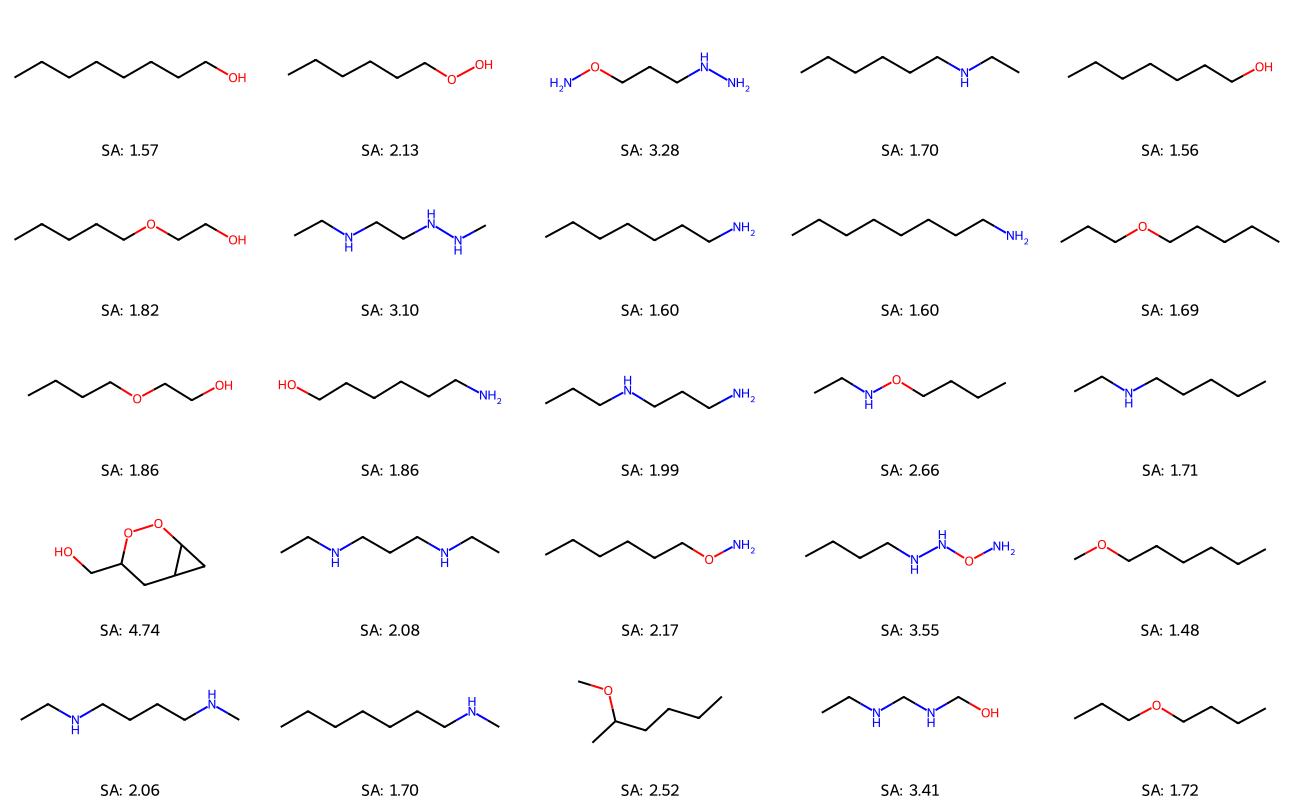

In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, rdMolDescriptors
from rdkit.Chem.rdmolops import GetMolFrags
from rdkit.Chem.Draw import MolsToGridImage
import sascorer  # Make sure to import sascorer

def is_synthesizable(mol, threshold=5.0):
    try:
        sa_score = sascorer.calculateScore(mol)
        return sa_score <= threshold
    except:
        return False

def get_sa_score(mol):
    """Get SA score for a molecule"""
    try:
        return sascorer.calculateScore(mol)
    except:
        return None

def is_normal_alkane(mol):
    if mol is None:
        return False
    mol = Chem.RemoveHs(mol)
    fragments = GetMolFrags(mol, asMols=True)
    if len(fragments) > 1:
        return False
    formula = rdMolDescriptors.CalcMolFormula(mol)
    if not formula.startswith('C') or any(x in formula for x in ['N', 'O', 'Cl', 'Br']):
        return False
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() != 6 or atom.GetHybridization() != Chem.HybridizationType.SP3 or atom.GetDegree() > 4:
            return False
    if mol.GetRingInfo().NumRings() > 0:
        return False
    return True

def is_valid_molecule(mol):
    if mol is None:
        return False
    try:
        Chem.SanitizeMol(mol)
    except:
        return False
    fragments = GetMolFrags(mol, asMols=True)
    if len(fragments) > 1:
        return False
    return True

# Sets to store unique SMILES
unique_smiles = set()
synthesizable_smiles = set()
all_valid_mols = []
mol_sa_scores = []  # Store SA scores corresponding to molecules

# Generate and process molecules
for _ in range(50):
    molecules = model.inference(1000)
    for mol in molecules:
        if mol is None or not is_valid_molecule(mol) or is_normal_alkane(mol):
            continue
        try:
            smiles = Chem.MolToSmiles(mol, canonical=True)
        except:
            continue
        if smiles not in unique_smiles:
            unique_smiles.add(smiles)
            sa_score = get_sa_score(mol)
            if sa_score is not None and is_synthesizable(mol):
                synthesizable_smiles.add(smiles)
                all_valid_mols.append(mol)
                mol_sa_scores.append(sa_score)

# Reporting
total_unique = len(unique_smiles)
total_synthesizable = len(synthesizable_smiles)
print(f"Total unique, valid, non-normal-alkane molecules: {total_unique}")
print(f"Unique synthesizable among them: {total_synthesizable}")
print(f"Synthesizable Unique / Total Unique: {100 * total_synthesizable / total_unique:.2f}%" if total_unique else "No valid molecules.")

# Visualize with SA scores
if all_valid_mols:
    # Create legends with SA scores
    legends = [f"SA: {score:.2f}" for score in mol_sa_scores[:25]]

    # Generate image with SA score labels
    img = MolsToGridImage(
        all_valid_mols[:25],
        molsPerRow=5,
        subImgSize=(260, 160),
        legends=legends
    )

    # Display or save the image
    display(img)  # For Jupyter notebooks
    # img.save('molecules_with_sa_scores.png')  # Uncomment to save to file
else:
    print("No synthesizable molecules found to visualize.")

In [ ]:
def plot_latent_simple(vae, data):
    # Get latent representations
    z_mean, _ = vae.encoder.predict(data)

    plt.figure(figsize=(10, 8))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], alpha=0.6)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.title("Latent Space Distribution")
    plt.show()

    # Print some statistics
    print(f"Latent space statistics:")
    print(f"z[0] - mean: {z_mean[:, 0].mean():.3f}, std: {z_mean[:, 0].std():.3f}")
    print(f"z[1] - mean: {z_mean[:, 1].mean():.3f}, std: {z_mean[:, 1].std():.3f}")

In [ ]:
from sklearn.cluster import KMeans

def plot_latent_clusters(vae, data, n_clusters=8):
    # Get latent representations
    z_mean, _ = vae.encoder.predict(data)

    # Perform clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(z_mean)

    # Plot
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=cluster_labels, cmap='tab10')
    plt.colorbar(scatter)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.title("Latent Space Clusters")
    plt.show()

    return cluster_labels

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


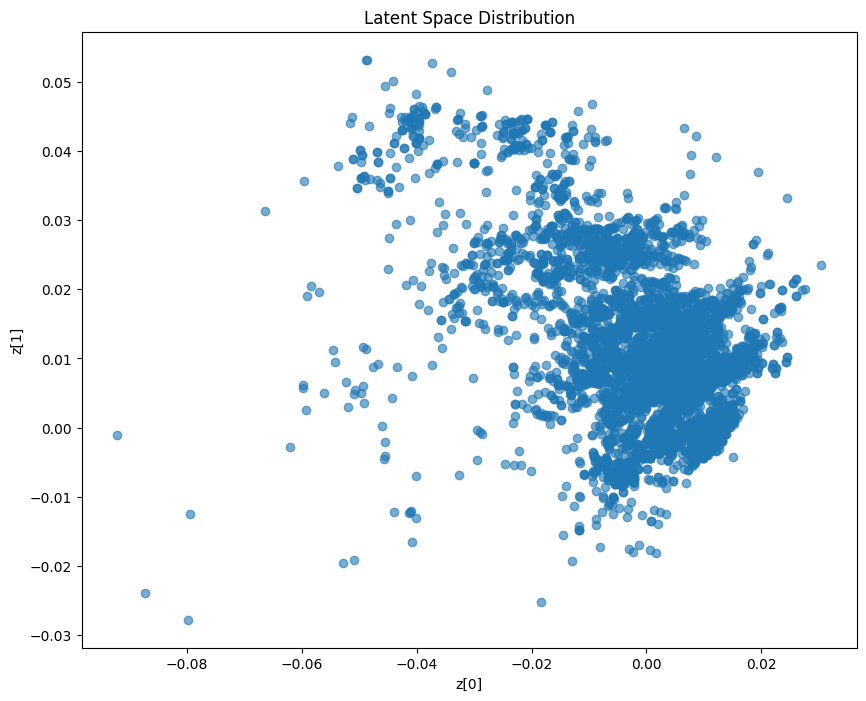

Latent space statistics:
z[0] - mean: 0.000, std: 0.012
z[1] - mean: 0.010, std: 0.010
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


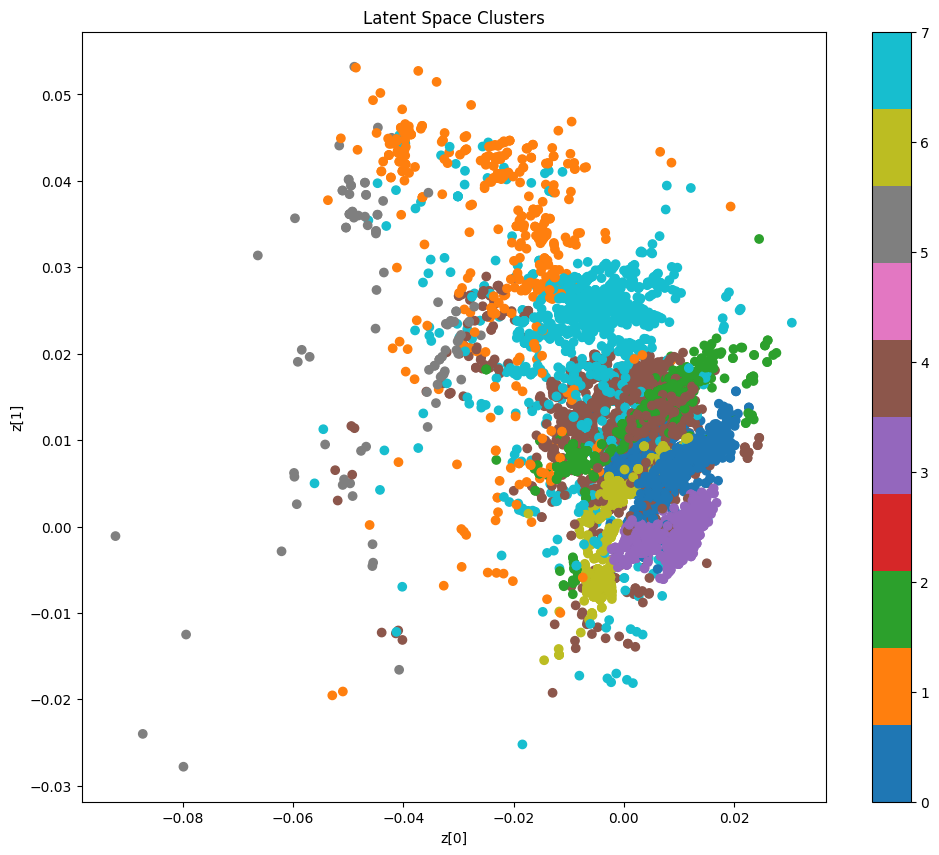

In [ ]:
# Simple visualization
plot_latent_simple(model, [adjacency_tensor[:8000], feature_tensor[:8000]])

# Or with clustering
cluster_labels = plot_latent_clusters(model, [adjacency_tensor[:8000], feature_tensor[:8000]])

#1,00,000

In [ ]:
MAX_SAMPLES = 100000

In [ ]:
adjacency_tensor, feature_tensor = [], []

for idx in range(len(df)):
    if len(adjacency_tensor) >= MAX_SAMPLES:
        break

    smiles = df.loc[idx]["SMILES"]

    try:
        adjacency, features = smiles_to_graph(smiles)

        if features.shape[0] > MAX_ATOMS:
            continue  # Skip large molecules

        # Pad to fixed size
        padded_adj = np.zeros((adjacency.shape[0], MAX_ATOMS, MAX_ATOMS), dtype=np.float32)
        padded_feat = np.zeros((MAX_ATOMS, features.shape[1]), dtype=np.float32)

        num_atoms = features.shape[0]
        padded_adj[:, :num_atoms, :num_atoms] = adjacency
        padded_feat[:num_atoms] = features

        adjacency_tensor.append(padded_adj)
        feature_tensor.append(padded_feat)

        if len(adjacency_tensor) % 100 == 0:
            print(f"Processed {len(adjacency_tensor)} molecules...")

    except Exception as e:
        print(f"Skipping idx={idx}, error: {e}")
        continue

adjacency_tensor = np.array(adjacency_tensor)
feature_tensor = np.array(feature_tensor)

print("Finished loading data!")
print("Adjacency tensor shape:", adjacency_tensor.shape)
print("Feature tensor shape:", feature_tensor.shape)



class RelationalGraphConvLayer(keras.layers.Layer):
    def __init__(
        self,
        units=128,
        activation="relu",
        use_bias=False,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.units = units
        self.activation = keras.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = keras.regularizers.get(bias_regularizer)

    def build(self, input_shape):
        bond_dim = input_shape[0][1]
        atom_dim = input_shape[1][2]

        self.kernel = self.add_weight(
            shape=(bond_dim, atom_dim, self.units),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            trainable=True,
            name="W",
            dtype="float32",
        )

        if self.use_bias:
            self.bias = self.add_weight(
                shape=(bond_dim, 1, self.units),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                trainable=True,
                name="b",
                dtype="float32",
            )

        self.built = True

    def call(self, inputs, training=False):
        adjacency, features = inputs
        # Aggregate information from neighbors
        x = ops.matmul(adjacency, features[:, None])
        # Apply linear transformation
        x = ops.matmul(x, self.kernel)
        if self.use_bias:
            x += self.bias
        # Reduce bond types dim
        x_reduced = ops.sum(x, axis=1)
        # Apply non-linear transformation
        return self.activation(x_reduced)


Processed 100 molecules...
Processed 200 molecules...
Processed 300 molecules...
Processed 400 molecules...
Processed 500 molecules...
Processed 600 molecules...
Processed 700 molecules...
Processed 800 molecules...
Processed 900 molecules...
Processed 1000 molecules...
Processed 1100 molecules...
Processed 1200 molecules...
Processed 1300 molecules...
Processed 1400 molecules...
Processed 1500 molecules...
Processed 1600 molecules...
Processed 1700 molecules...
Processed 1800 molecules...
Processed 1900 molecules...
Processed 2000 molecules...
Processed 2100 molecules...
Processed 2200 molecules...
Processed 2300 molecules...
Processed 2400 molecules...
Processed 2500 molecules...
Processed 2600 molecules...
Processed 2700 molecules...
Processed 2800 molecules...
Processed 2900 molecules...
Processed 3000 molecules...
Processed 3100 molecules...
Processed 3200 molecules...
Processed 3300 molecules...
Processed 3400 molecules...
Processed 3500 molecules...
Processed 3600 molecules...
P

In [ ]:
vae_optimizer = keras.optimizers.Adam(learning_rate=1e-5)

encoder = get_encoder(
    gconv_units=[9],
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
    latent_dim=LATENT_DIM,
    dense_units=[512],
    dropout_rate=0.0,
)
decoder = get_decoder(
    dense_units=[128, 256, 512],
    dropout_rate=0.2,
    latent_dim=LATENT_DIM,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
)

model = MoleculeGenerator(encoder, decoder, MAX_MOLSIZE)

model.compile(vae_optimizer)
history = model.fit([adjacency_tensor, feature_tensor], epochs=EPOCHS)


Epoch 1/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 129.1916
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 49.5942
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 48.6800
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 48.2850
Epoch 5/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 48.1609
Epoch 6/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 47.9305
Epoch 7/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 47.2800
Epoch 8/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 47.0360
Epoch 9/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 46.7008
Epoch 10/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 46.4415


Total unique, valid, non-normal-alkane molecules: 795
Unique synthesizable among them: 751
Synthesizable Unique / Total Unique: 94.47%


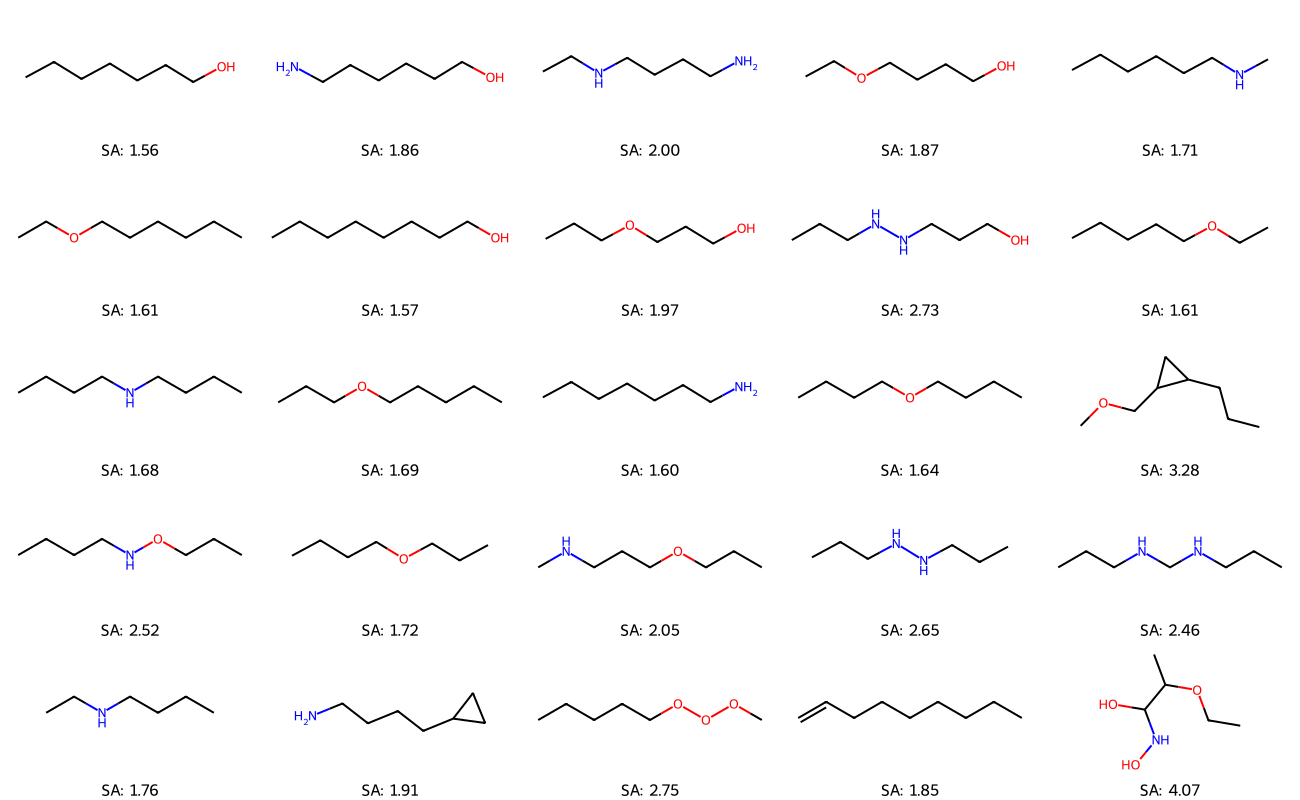

In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, rdMolDescriptors
from rdkit.Chem.rdmolops import GetMolFrags
from rdkit.Chem.Draw import MolsToGridImage
import sascorer  # Make sure to import sascorer

def is_synthesizable(mol, threshold=5.0):
    try:
        sa_score = sascorer.calculateScore(mol)
        return sa_score <= threshold
    except:
        return False

def get_sa_score(mol):
    """Get SA score for a molecule"""
    try:
        return sascorer.calculateScore(mol)
    except:
        return None

def is_normal_alkane(mol):
    if mol is None:
        return False
    mol = Chem.RemoveHs(mol)
    fragments = GetMolFrags(mol, asMols=True)
    if len(fragments) > 1:
        return False
    formula = rdMolDescriptors.CalcMolFormula(mol)
    if not formula.startswith('C') or any(x in formula for x in ['N', 'O', 'Cl', 'Br']):
        return False
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() != 6 or atom.GetHybridization() != Chem.HybridizationType.SP3 or atom.GetDegree() > 4:
            return False
    if mol.GetRingInfo().NumRings() > 0:
        return False
    return True

def is_valid_molecule(mol):
    if mol is None:
        return False
    try:
        Chem.SanitizeMol(mol)
    except:
        return False
    fragments = GetMolFrags(mol, asMols=True)
    if len(fragments) > 1:
        return False
    return True

# Sets to store unique SMILES
unique_smiles = set()
synthesizable_smiles = set()
all_valid_mols = []
mol_sa_scores = []  # Store SA scores corresponding to molecules

# Generate and process molecules
for _ in range(50):
    molecules = model.inference(1000)
    for mol in molecules:
        if mol is None or not is_valid_molecule(mol) or is_normal_alkane(mol):
            continue
        try:
            smiles = Chem.MolToSmiles(mol, canonical=True)
        except:
            continue
        if smiles not in unique_smiles:
            unique_smiles.add(smiles)
            sa_score = get_sa_score(mol)
            if sa_score is not None and is_synthesizable(mol):
                synthesizable_smiles.add(smiles)
                all_valid_mols.append(mol)
                mol_sa_scores.append(sa_score)

# Reporting
total_unique = len(unique_smiles)
total_synthesizable = len(synthesizable_smiles)
print(f"Total unique, valid, non-normal-alkane molecules: {total_unique}")
print(f"Unique synthesizable among them: {total_synthesizable}")
print(f"Synthesizable Unique / Total Unique: {100 * total_synthesizable / total_unique:.2f}%" if total_unique else "No valid molecules.")

# Visualize with SA scores
if all_valid_mols:
    # Create legends with SA scores
    legends = [f"SA: {score:.2f}" for score in mol_sa_scores[:25]]

    # Generate image with SA score labels
    img = MolsToGridImage(
        all_valid_mols[:25],
        molsPerRow=5,
        subImgSize=(260, 160),
        legends=legends
    )

    # Display or save the image
    display(img)  # For Jupyter notebooks
    # img.save('molecules_with_sa_scores.png')  # Uncomment to save to file
else:
    print("No synthesizable molecules found to visualize.")

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


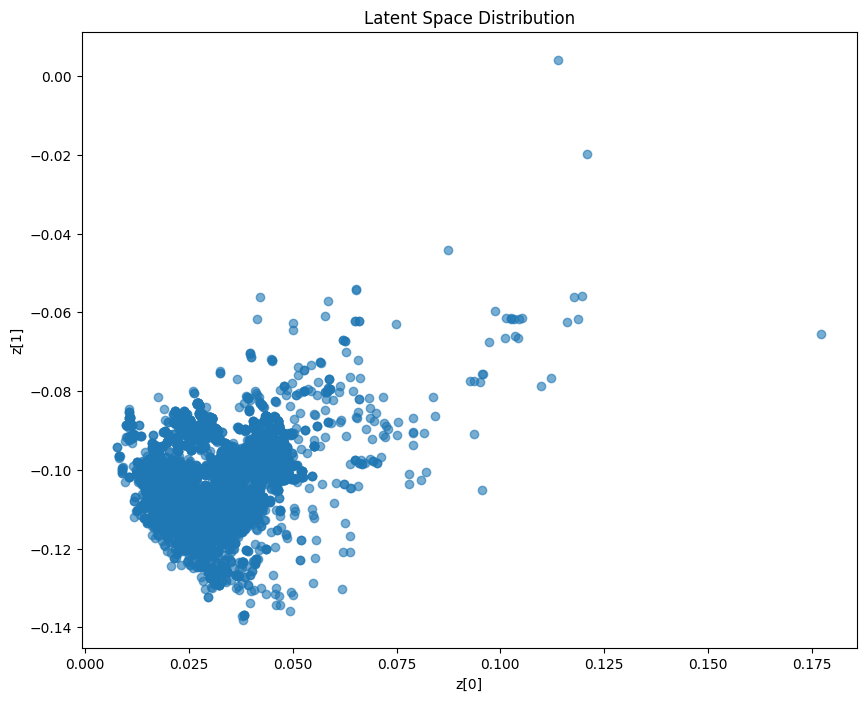

Latent space statistics:
z[0] - mean: 0.033, std: 0.012
z[1] - mean: -0.102, std: 0.010
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


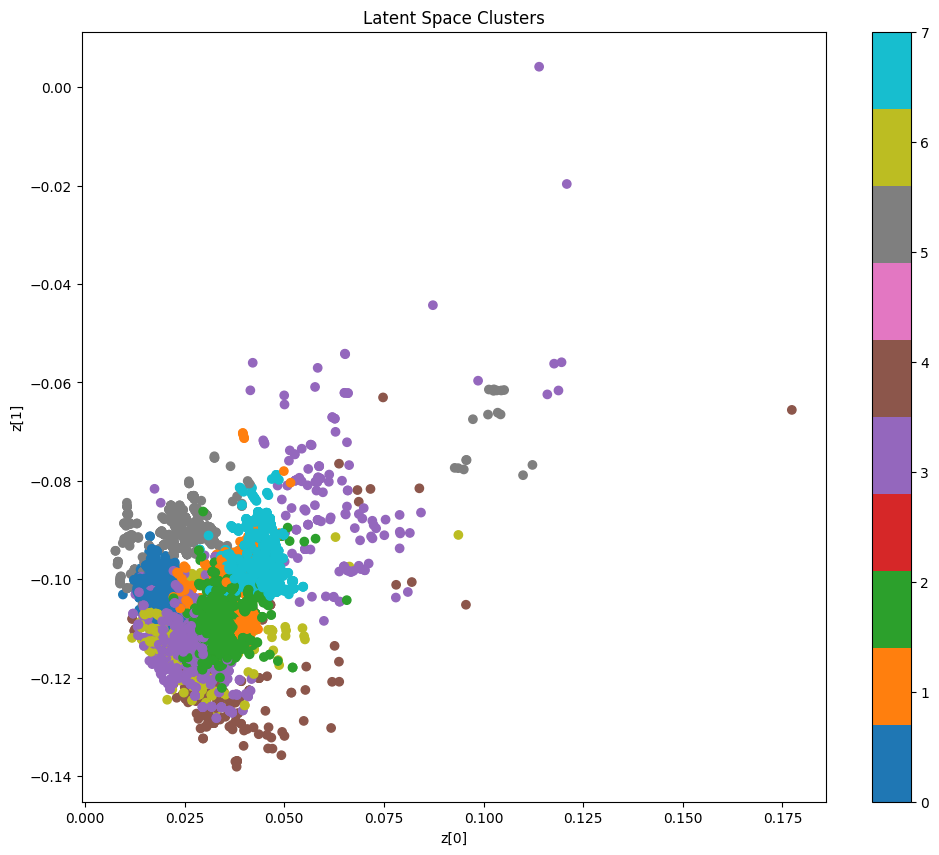

In [ ]:
# Simple visualization
plot_latent_simple(model, [adjacency_tensor[:8000], feature_tensor[:8000]])

# Or with clustering
cluster_labels = plot_latent_clusters(model, [adjacency_tensor[:8000], feature_tensor[:8000]])

#50,000


In [ ]:
MAX_SAMPLES = 50000

In [ ]:
adjacency_tensor, feature_tensor = [], []

for idx in range(len(df)):
    if len(adjacency_tensor) >= MAX_SAMPLES:
        break

    smiles = df.loc[idx]["SMILES"]

    try:
        adjacency, features = smiles_to_graph(smiles)

        if features.shape[0] > MAX_ATOMS:
            continue  # Skip large molecules

        # Pad to fixed size
        padded_adj = np.zeros((adjacency.shape[0], MAX_ATOMS, MAX_ATOMS), dtype=np.float32)
        padded_feat = np.zeros((MAX_ATOMS, features.shape[1]), dtype=np.float32)

        num_atoms = features.shape[0]
        padded_adj[:, :num_atoms, :num_atoms] = adjacency
        padded_feat[:num_atoms] = features

        adjacency_tensor.append(padded_adj)
        feature_tensor.append(padded_feat)

        if len(adjacency_tensor) % 100 == 0:
            print(f"Processed {len(adjacency_tensor)} molecules...")

    except Exception as e:
        print(f"Skipping idx={idx}, error: {e}")
        continue

adjacency_tensor = np.array(adjacency_tensor)
feature_tensor = np.array(feature_tensor)

print("Finished loading data!")
print("Adjacency tensor shape:", adjacency_tensor.shape)
print("Feature tensor shape:", feature_tensor.shape)



class RelationalGraphConvLayer(keras.layers.Layer):
    def __init__(
        self,
        units=128,
        activation="relu",
        use_bias=False,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.units = units
        self.activation = keras.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = keras.regularizers.get(bias_regularizer)

    def build(self, input_shape):
        bond_dim = input_shape[0][1]
        atom_dim = input_shape[1][2]

        self.kernel = self.add_weight(
            shape=(bond_dim, atom_dim, self.units),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            trainable=True,
            name="W",
            dtype="float32",
        )

        if self.use_bias:
            self.bias = self.add_weight(
                shape=(bond_dim, 1, self.units),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                trainable=True,
                name="b",
                dtype="float32",
            )

        self.built = True

    def call(self, inputs, training=False):
        adjacency, features = inputs
        # Aggregate information from neighbors
        x = ops.matmul(adjacency, features[:, None])
        # Apply linear transformation
        x = ops.matmul(x, self.kernel)
        if self.use_bias:
            x += self.bias
        # Reduce bond types dim
        x_reduced = ops.sum(x, axis=1)
        # Apply non-linear transformation
        return self.activation(x_reduced)


Processed 100 molecules...
Processed 200 molecules...
Processed 300 molecules...
Processed 400 molecules...
Processed 500 molecules...
Processed 600 molecules...
Processed 700 molecules...
Processed 800 molecules...
Processed 900 molecules...
Processed 1000 molecules...
Processed 1100 molecules...
Processed 1200 molecules...
Processed 1300 molecules...
Processed 1400 molecules...
Processed 1500 molecules...
Processed 1600 molecules...
Processed 1700 molecules...
Processed 1800 molecules...
Processed 1900 molecules...
Processed 2000 molecules...
Processed 2100 molecules...
Processed 2200 molecules...
Processed 2300 molecules...
Processed 2400 molecules...
Processed 2500 molecules...
Processed 2600 molecules...
Processed 2700 molecules...
Processed 2800 molecules...
Processed 2900 molecules...
Processed 3000 molecules...
Processed 3100 molecules...
Processed 3200 molecules...
Processed 3300 molecules...
Processed 3400 molecules...
Processed 3500 molecules...
Processed 3600 molecules...
P

In [ ]:
vae_optimizer = keras.optimizers.Adam(learning_rate=1e-5)

encoder = get_encoder(
    gconv_units=[9],
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
    latent_dim=LATENT_DIM,
    dense_units=[512],
    dropout_rate=0.0,
)
decoder = get_decoder(
    dense_units=[128, 256, 512],
    dropout_rate=0.2,
    latent_dim=LATENT_DIM,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
)

model = MoleculeGenerator(encoder, decoder, MAX_MOLSIZE)

model.compile(vae_optimizer)
history = model.fit([adjacency_tensor, feature_tensor], epochs=EPOCHS)


Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 184.4956
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 55.0459
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 51.7227
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 50.9290
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 50.4776
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 50.3714
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 50.1455
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 49.9726
Epoch 9/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 49.7073
Epoch 10/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 49.5735


Total unique, valid, non-normal-alkane molecules: 975
Unique synthesizable among them: 928
Synthesizable Unique / Total Unique: 95.18%


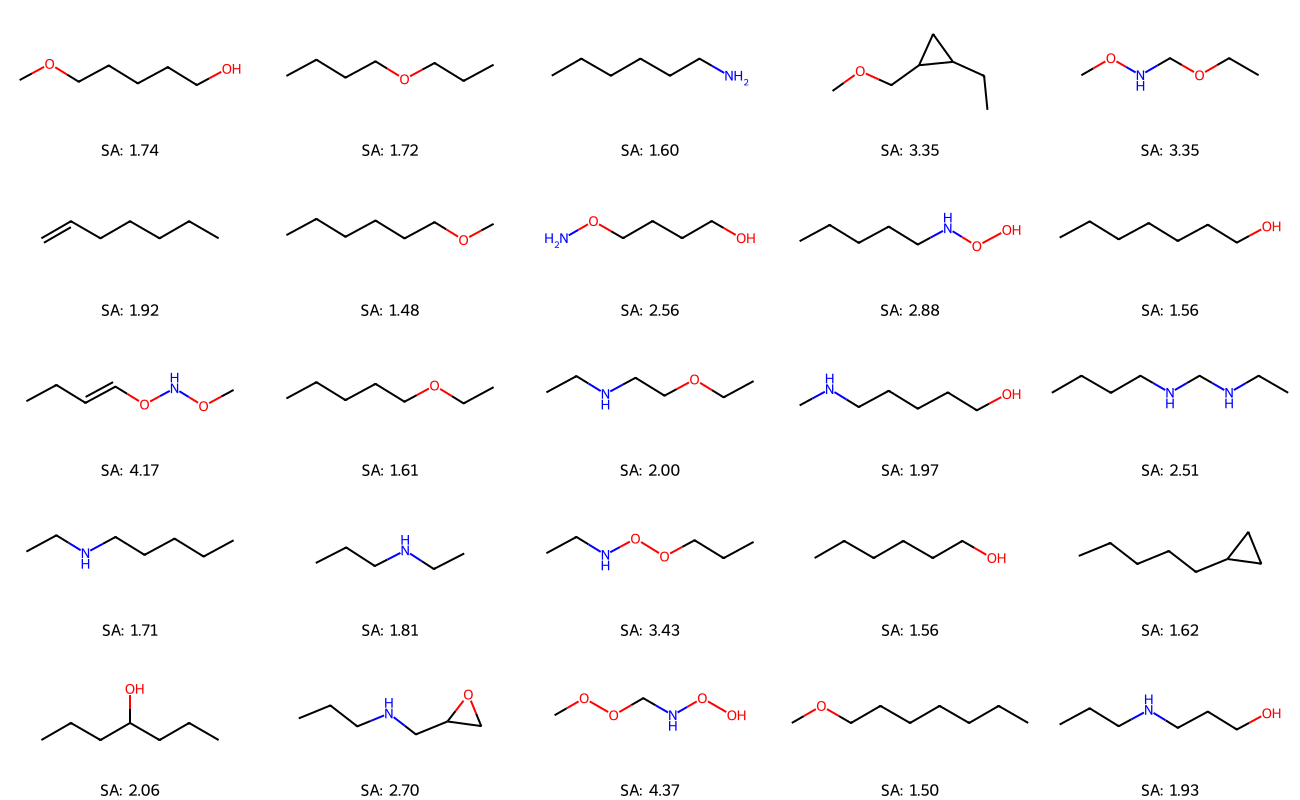

In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, rdMolDescriptors
from rdkit.Chem.rdmolops import GetMolFrags
from rdkit.Chem.Draw import MolsToGridImage
import sascorer  # Make sure to import sascorer

def is_synthesizable(mol, threshold=5.0):
    try:
        sa_score = sascorer.calculateScore(mol)
        return sa_score <= threshold
    except:
        return False

def get_sa_score(mol):
    """Get SA score for a molecule"""
    try:
        return sascorer.calculateScore(mol)
    except:
        return None

def is_normal_alkane(mol):
    if mol is None:
        return False
    mol = Chem.RemoveHs(mol)
    fragments = GetMolFrags(mol, asMols=True)
    if len(fragments) > 1:
        return False
    formula = rdMolDescriptors.CalcMolFormula(mol)
    if not formula.startswith('C') or any(x in formula for x in ['N', 'O', 'Cl', 'Br']):
        return False
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() != 6 or atom.GetHybridization() != Chem.HybridizationType.SP3 or atom.GetDegree() > 4:
            return False
    if mol.GetRingInfo().NumRings() > 0:
        return False
    return True

def is_valid_molecule(mol):
    if mol is None:
        return False
    try:
        Chem.SanitizeMol(mol)
    except:
        return False
    fragments = GetMolFrags(mol, asMols=True)
    if len(fragments) > 1:
        return False
    return True

# Sets to store unique SMILES
unique_smiles = set()
synthesizable_smiles = set()
all_valid_mols = []
mol_sa_scores = []  # Store SA scores corresponding to molecules

# Generate and process molecules
for _ in range(50):
    molecules = model.inference(1000)
    for mol in molecules:
        if mol is None or not is_valid_molecule(mol) or is_normal_alkane(mol):
            continue
        try:
            smiles = Chem.MolToSmiles(mol, canonical=True)
        except:
            continue
        if smiles not in unique_smiles:
            unique_smiles.add(smiles)
            sa_score = get_sa_score(mol)
            if sa_score is not None and is_synthesizable(mol):
                synthesizable_smiles.add(smiles)
                all_valid_mols.append(mol)
                mol_sa_scores.append(sa_score)

# Reporting
total_unique = len(unique_smiles)
total_synthesizable = len(synthesizable_smiles)
print(f"Total unique, valid, non-normal-alkane molecules: {total_unique}")
print(f"Unique synthesizable among them: {total_synthesizable}")
print(f"Synthesizable Unique / Total Unique: {100 * total_synthesizable / total_unique:.2f}%" if total_unique else "No valid molecules.")

# Visualize with SA scores
if all_valid_mols:
    # Create legends with SA scores
    legends = [f"SA: {score:.2f}" for score in mol_sa_scores[:25]]

    # Generate image with SA score labels
    img = MolsToGridImage(
        all_valid_mols[:25],
        molsPerRow=5,
        subImgSize=(260, 160),
        legends=legends
    )

    # Display or save the image
    display(img)  # For Jupyter notebooks
    # img.save('molecules_with_sa_scores.png')  # Uncomment to save to file
else:
    print("No synthesizable molecules found to visualize.")

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


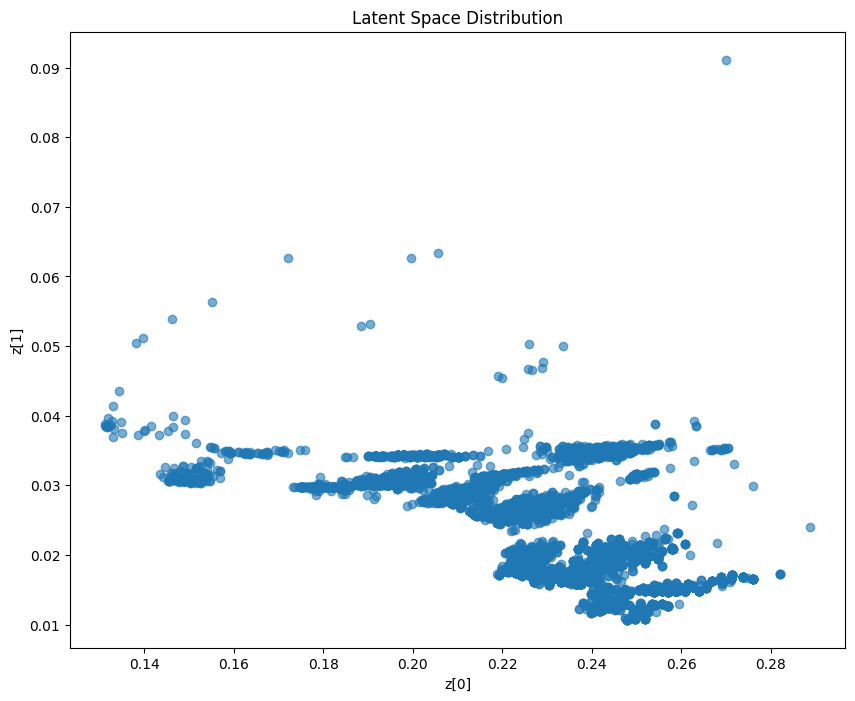

Latent space statistics:
z[0] - mean: 0.230, std: 0.023
z[1] - mean: 0.024, std: 0.007
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


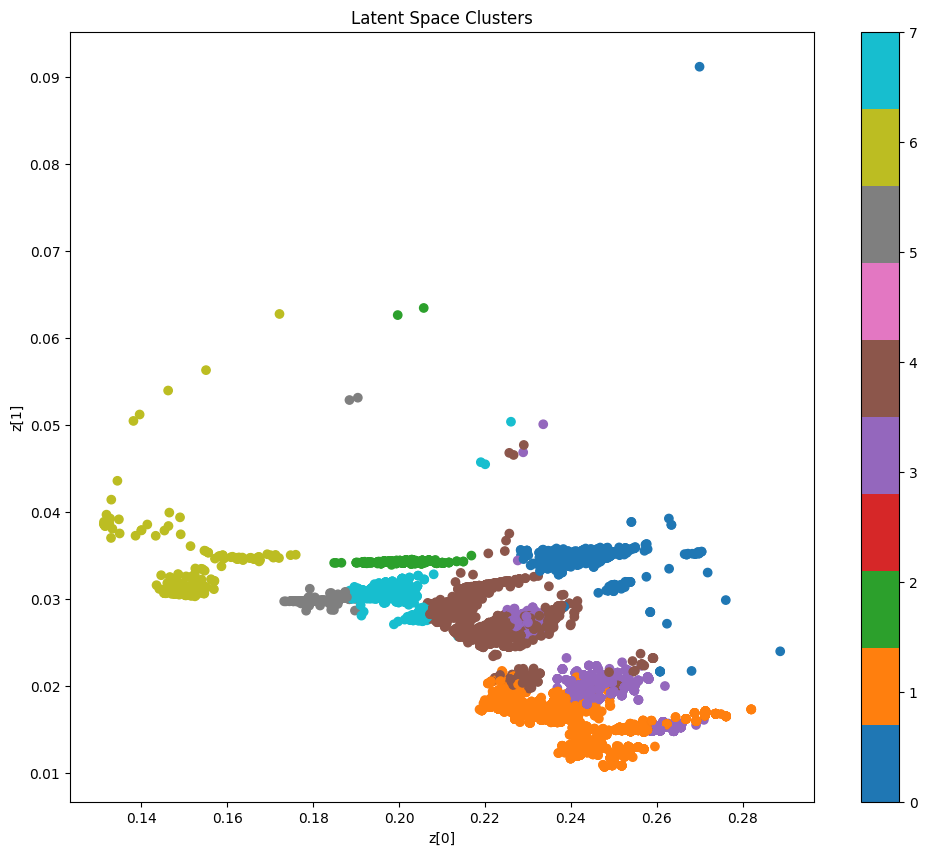

In [ ]:
# Simple visualization
plot_latent_simple(model, [adjacency_tensor[:8000], feature_tensor[:8000]])

# Or with clustering
cluster_labels = plot_latent_clusters(model, [adjacency_tensor[:8000], feature_tensor[:8000]])

#25,000

In [ ]:
MAX_SAMPLES = 25000

In [ ]:
adjacency_tensor, feature_tensor = [], []

for idx in range(len(df)):
    if len(adjacency_tensor) >= MAX_SAMPLES:
        break

    smiles = df.loc[idx]["SMILES"]

    try:
        adjacency, features = smiles_to_graph(smiles)

        if features.shape[0] > MAX_ATOMS:
            continue  # Skip large molecules

        # Pad to fixed size
        padded_adj = np.zeros((adjacency.shape[0], MAX_ATOMS, MAX_ATOMS), dtype=np.float32)
        padded_feat = np.zeros((MAX_ATOMS, features.shape[1]), dtype=np.float32)

        num_atoms = features.shape[0]
        padded_adj[:, :num_atoms, :num_atoms] = adjacency
        padded_feat[:num_atoms] = features

        adjacency_tensor.append(padded_adj)
        feature_tensor.append(padded_feat)

        if len(adjacency_tensor) % 100 == 0:
            print(f"Processed {len(adjacency_tensor)} molecules...")

    except Exception as e:
        print(f"Skipping idx={idx}, error: {e}")
        continue

adjacency_tensor = np.array(adjacency_tensor)
feature_tensor = np.array(feature_tensor)

print("Finished loading data!")
print("Adjacency tensor shape:", adjacency_tensor.shape)
print("Feature tensor shape:", feature_tensor.shape)



class RelationalGraphConvLayer(keras.layers.Layer):
    def __init__(
        self,
        units=128,
        activation="relu",
        use_bias=False,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.units = units
        self.activation = keras.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = keras.regularizers.get(bias_regularizer)

    def build(self, input_shape):
        bond_dim = input_shape[0][1]
        atom_dim = input_shape[1][2]

        self.kernel = self.add_weight(
            shape=(bond_dim, atom_dim, self.units),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            trainable=True,
            name="W",
            dtype="float32",
        )

        if self.use_bias:
            self.bias = self.add_weight(
                shape=(bond_dim, 1, self.units),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                trainable=True,
                name="b",
                dtype="float32",
            )

        self.built = True

    def call(self, inputs, training=False):
        adjacency, features = inputs
        # Aggregate information from neighbors
        x = ops.matmul(adjacency, features[:, None])
        # Apply linear transformation
        x = ops.matmul(x, self.kernel)
        if self.use_bias:
            x += self.bias
        # Reduce bond types dim
        x_reduced = ops.sum(x, axis=1)
        # Apply non-linear transformation
        return self.activation(x_reduced)


Processed 100 molecules...
Processed 200 molecules...
Processed 300 molecules...
Processed 400 molecules...
Processed 500 molecules...
Processed 600 molecules...
Processed 700 molecules...
Processed 800 molecules...
Processed 900 molecules...
Processed 1000 molecules...
Processed 1100 molecules...
Processed 1200 molecules...
Processed 1300 molecules...
Processed 1400 molecules...
Processed 1500 molecules...
Processed 1600 molecules...
Processed 1700 molecules...
Processed 1800 molecules...
Processed 1900 molecules...
Processed 2000 molecules...
Processed 2100 molecules...
Processed 2200 molecules...
Processed 2300 molecules...
Processed 2400 molecules...
Processed 2500 molecules...
Processed 2600 molecules...
Processed 2700 molecules...
Processed 2800 molecules...
Processed 2900 molecules...
Processed 3000 molecules...
Processed 3100 molecules...
Processed 3200 molecules...
Processed 3300 molecules...
Processed 3400 molecules...
Processed 3500 molecules...
Processed 3600 molecules...
P

In [ ]:
vae_optimizer = keras.optimizers.Adam(learning_rate=1e-5)

encoder = get_encoder(
    gconv_units=[9],
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
    latent_dim=LATENT_DIM,
    dense_units=[512],
    dropout_rate=0.0,
)
decoder = get_decoder(
    dense_units=[128, 256, 512],
    dropout_rate=0.2,
    latent_dim=LATENT_DIM,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
)

model = MoleculeGenerator(encoder, decoder, MAX_MOLSIZE)

model.compile(vae_optimizer)
history = model.fit([adjacency_tensor, feature_tensor], epochs=EPOCHS)


Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 215.1056
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 55.1758
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 49.2351
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 48.1793
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 47.3596
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 47.0838
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 46.6161
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 46.4050
Epoch 9/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 46.4059
Epoch 10/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 46.1780


Total unique, valid, non-normal-alkane molecules: 1132
Unique synthesizable among them: 1075
Synthesizable Unique / Total Unique: 94.96%


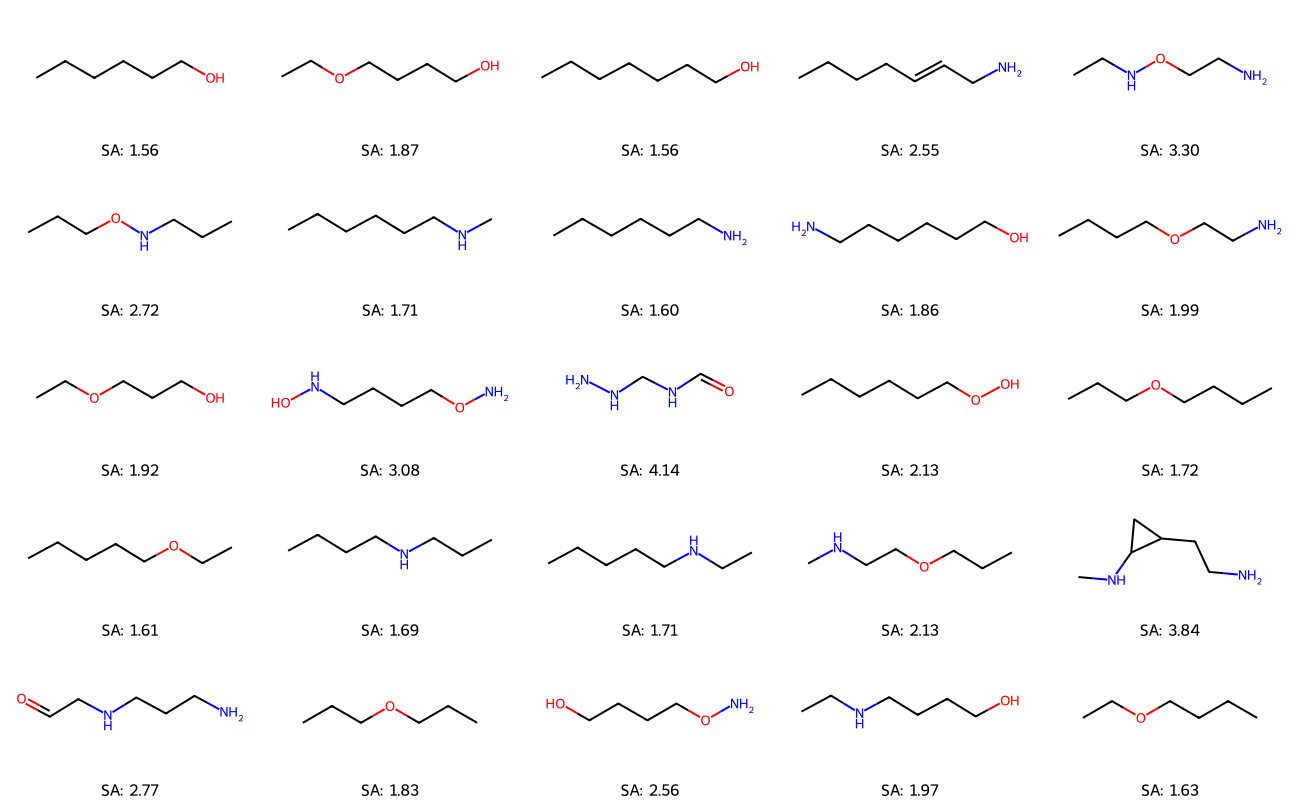

In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, rdMolDescriptors
from rdkit.Chem.rdmolops import GetMolFrags
from rdkit.Chem.Draw import MolsToGridImage
import sascorer  # Make sure to import sascorer

def is_synthesizable(mol, threshold=5.0):
    try:
        sa_score = sascorer.calculateScore(mol)
        return sa_score <= threshold
    except:
        return False

def get_sa_score(mol):
    """Get SA score for a molecule"""
    try:
        return sascorer.calculateScore(mol)
    except:
        return None

def is_normal_alkane(mol):
    if mol is None:
        return False
    mol = Chem.RemoveHs(mol)
    fragments = GetMolFrags(mol, asMols=True)
    if len(fragments) > 1:
        return False
    formula = rdMolDescriptors.CalcMolFormula(mol)
    if not formula.startswith('C') or any(x in formula for x in ['N', 'O', 'Cl', 'Br']):
        return False
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() != 6 or atom.GetHybridization() != Chem.HybridizationType.SP3 or atom.GetDegree() > 4:
            return False
    if mol.GetRingInfo().NumRings() > 0:
        return False
    return True

def is_valid_molecule(mol):
    if mol is None:
        return False
    try:
        Chem.SanitizeMol(mol)
    except:
        return False
    fragments = GetMolFrags(mol, asMols=True)
    if len(fragments) > 1:
        return False
    return True

# Sets to store unique SMILES
unique_smiles = set()
synthesizable_smiles = set()
all_valid_mols = []
mol_sa_scores = []  # Store SA scores corresponding to molecules

# Generate and process molecules
for _ in range(50):
    molecules = model.inference(1000)
    for mol in molecules:
        if mol is None or not is_valid_molecule(mol) or is_normal_alkane(mol):
            continue
        try:
            smiles = Chem.MolToSmiles(mol, canonical=True)
        except:
            continue
        if smiles not in unique_smiles:
            unique_smiles.add(smiles)
            sa_score = get_sa_score(mol)
            if sa_score is not None and is_synthesizable(mol):
                synthesizable_smiles.add(smiles)
                all_valid_mols.append(mol)
                mol_sa_scores.append(sa_score)

# Reporting
total_unique = len(unique_smiles)
total_synthesizable = len(synthesizable_smiles)
print(f"Total unique, valid, non-normal-alkane molecules: {total_unique}")
print(f"Unique synthesizable among them: {total_synthesizable}")
print(f"Synthesizable Unique / Total Unique: {100 * total_synthesizable / total_unique:.2f}%" if total_unique else "No valid molecules.")

# Visualize with SA scores
if all_valid_mols:
    # Create legends with SA scores
    legends = [f"SA: {score:.2f}" for score in mol_sa_scores[:25]]

    # Generate image with SA score labels
    img = MolsToGridImage(
        all_valid_mols[:25],
        molsPerRow=5,
        subImgSize=(260, 160),
        legends=legends
    )

    # Display or save the image
    display(img)  # For Jupyter notebooks
    # img.save('molecules_with_sa_scores.png')  # Uncomment to save to file
else:
    print("No synthesizable molecules found to visualize.")

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

def get_latent_vectors(vae, mols):
    """Get latent vectors from SMILES using the encoder."""
    smiles_list = [Chem.MolToSmiles(m) for m in mols]
    indices = [[SMILE_to_index.get(c, 0) for c in s] for s in smiles_list]

    # Pad or truncate to NUM_ATOMS
    padded = np.zeros((len(indices), NUM_ATOMS), dtype=int)
    for i, seq in enumerate(indices):
        truncated = seq[:NUM_ATOMS]
        padded[i, :len(truncated)] = truncated

    z_mean, _ = vae.encoder.predict(padded)
    return z_mean

def plot_clusters_2D(z_mean, labels=None, method='pca', title='Latent Space Clustering'):
    if method == 'tsne':
        z_proj = TSNE(n_components=2, random_state=42).fit_transform(z_mean)
    else:
        z_proj = PCA(n_components=2).fit_transform(z_mean)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(z_proj[:, 0], z_proj[:, 1], c=labels, cmap='viridis', s=35, alpha=0.8)

    if labels is not None:
        plt.colorbar(scatter, label='Property Value')

    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    plt.show()


250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


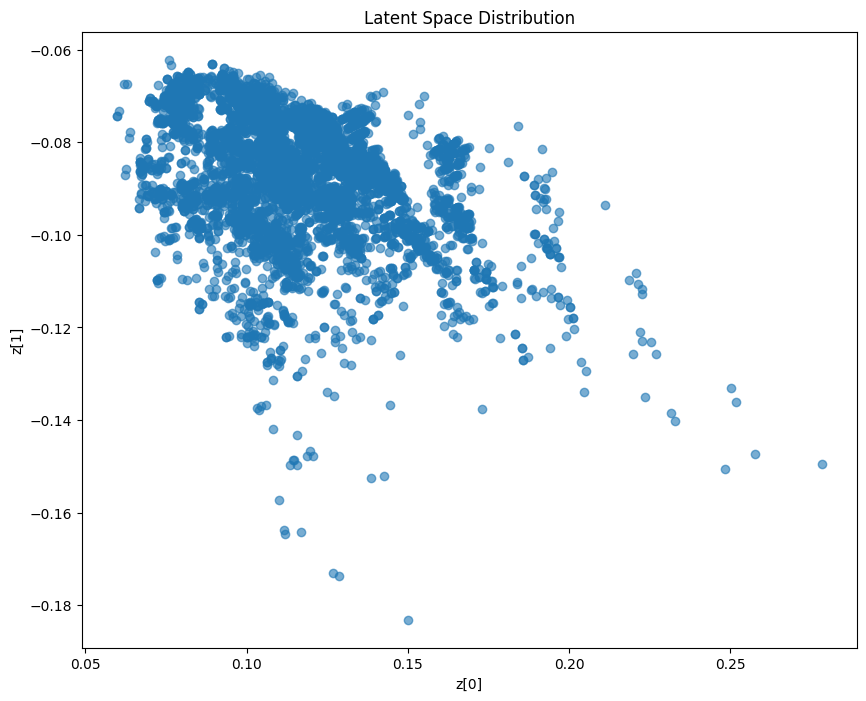

Latent space statistics:
z[0] - mean: 0.118, std: 0.023
z[1] - mean: -0.086, std: 0.012
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


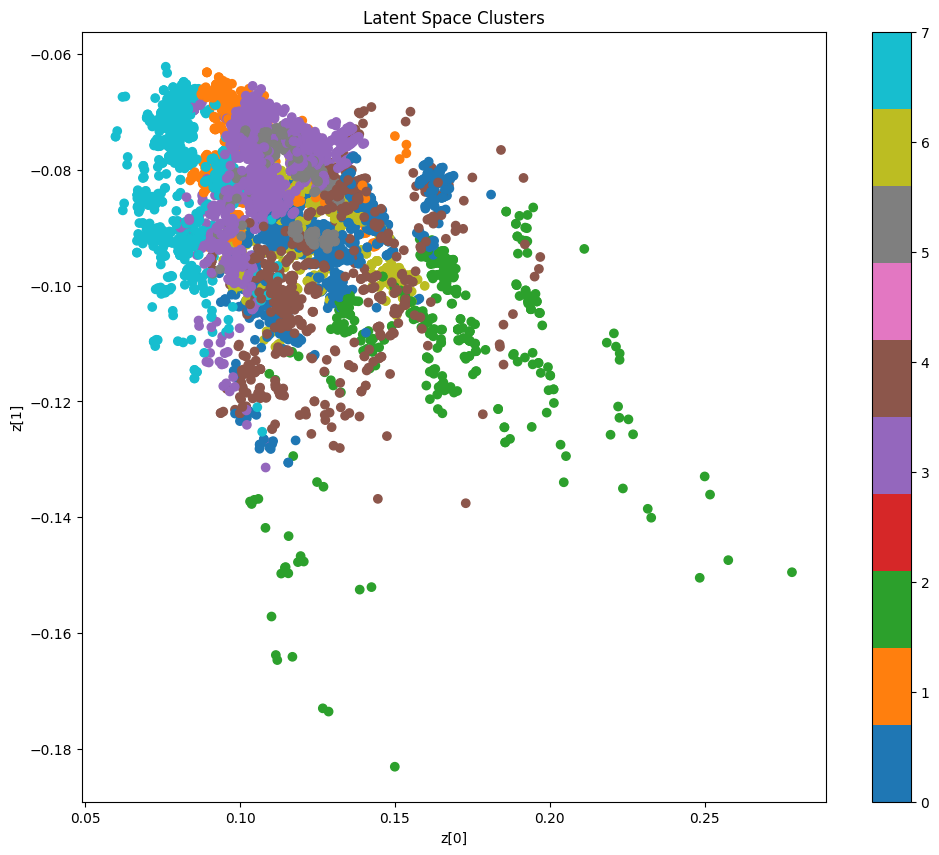

In [ ]:
# Simple visualization
plot_latent_simple(model, [adjacency_tensor[:8000], feature_tensor[:8000]])

# Or with clustering
cluster_labels = plot_latent_clusters(model, [adjacency_tensor[:8000], feature_tensor[:8000]])

#10,000

In [ ]:
MAX_SAMPLES = 10000

In [ ]:
adjacency_tensor, feature_tensor = [], []

for idx in range(len(df)):
    if len(adjacency_tensor) >= MAX_SAMPLES:
        break

    smiles = df.loc[idx]["SMILES"]

    try:
        adjacency, features = smiles_to_graph(smiles)

        if features.shape[0] > MAX_ATOMS:
            continue  # Skip large molecules

        # Pad to fixed size
        padded_adj = np.zeros((adjacency.shape[0], MAX_ATOMS, MAX_ATOMS), dtype=np.float32)
        padded_feat = np.zeros((MAX_ATOMS, features.shape[1]), dtype=np.float32)

        num_atoms = features.shape[0]
        padded_adj[:, :num_atoms, :num_atoms] = adjacency
        padded_feat[:num_atoms] = features

        adjacency_tensor.append(padded_adj)
        feature_tensor.append(padded_feat)

        if len(adjacency_tensor) % 100 == 0:
            print(f"Processed {len(adjacency_tensor)} molecules...")

    except Exception as e:
        print(f"Skipping idx={idx}, error: {e}")
        continue

adjacency_tensor = np.array(adjacency_tensor)
feature_tensor = np.array(feature_tensor)

print("Finished loading data!")
print("Adjacency tensor shape:", adjacency_tensor.shape)
print("Feature tensor shape:", feature_tensor.shape)



class RelationalGraphConvLayer(keras.layers.Layer):
    def __init__(
        self,
        units=128,
        activation="relu",
        use_bias=False,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.units = units
        self.activation = keras.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = keras.regularizers.get(bias_regularizer)

    def build(self, input_shape):
        bond_dim = input_shape[0][1]
        atom_dim = input_shape[1][2]

        self.kernel = self.add_weight(
            shape=(bond_dim, atom_dim, self.units),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            trainable=True,
            name="W",
            dtype="float32",
        )

        if self.use_bias:
            self.bias = self.add_weight(
                shape=(bond_dim, 1, self.units),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                trainable=True,
                name="b",
                dtype="float32",
            )

        self.built = True

    def call(self, inputs, training=False):
        adjacency, features = inputs
        # Aggregate information from neighbors
        x = ops.matmul(adjacency, features[:, None])
        # Apply linear transformation
        x = ops.matmul(x, self.kernel)
        if self.use_bias:
            x += self.bias
        # Reduce bond types dim
        x_reduced = ops.sum(x, axis=1)
        # Apply non-linear transformation
        return self.activation(x_reduced)


Processed 100 molecules...
Processed 200 molecules...
Processed 300 molecules...
Processed 400 molecules...
Processed 500 molecules...
Processed 600 molecules...
Processed 700 molecules...
Processed 800 molecules...
Processed 900 molecules...
Processed 1000 molecules...
Processed 1100 molecules...
Processed 1200 molecules...
Processed 1300 molecules...
Processed 1400 molecules...
Processed 1500 molecules...
Processed 1600 molecules...
Processed 1700 molecules...
Processed 1800 molecules...
Processed 1900 molecules...
Processed 2000 molecules...
Processed 2100 molecules...
Processed 2200 molecules...
Processed 2300 molecules...
Processed 2400 molecules...
Processed 2500 molecules...
Processed 2600 molecules...
Processed 2700 molecules...
Processed 2800 molecules...
Processed 2900 molecules...
Processed 3000 molecules...
Processed 3100 molecules...
Processed 3200 molecules...
Processed 3300 molecules...
Processed 3400 molecules...
Processed 3500 molecules...
Processed 3600 molecules...
P

In [ ]:
vae_optimizer = keras.optimizers.Adam(learning_rate=1e-5)

encoder = get_encoder(
    gconv_units=[9],
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
    latent_dim=LATENT_DIM,
    dense_units=[512],
    dropout_rate=0.0,
)
decoder = get_decoder(
    dense_units=[128, 256, 512],
    dropout_rate=0.2,
    latent_dim=LATENT_DIM,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
)

model = MoleculeGenerator(encoder, decoder, MAX_MOLSIZE)

model.compile(vae_optimizer)
history = model.fit([adjacency_tensor, feature_tensor], epochs=EPOCHS)


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 253.2710
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 107.8945
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 59.1929
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 51.4681
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 48.5390
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 47.0725
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 46.0414
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 45.8593
Epoch 9/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 45.0834
Epoch 10/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 45.0531


Total unique, valid, non-normal-alkane molecules: 1687
Unique synthesizable among them: 1560
Synthesizable Unique / Total Unique: 92.47%


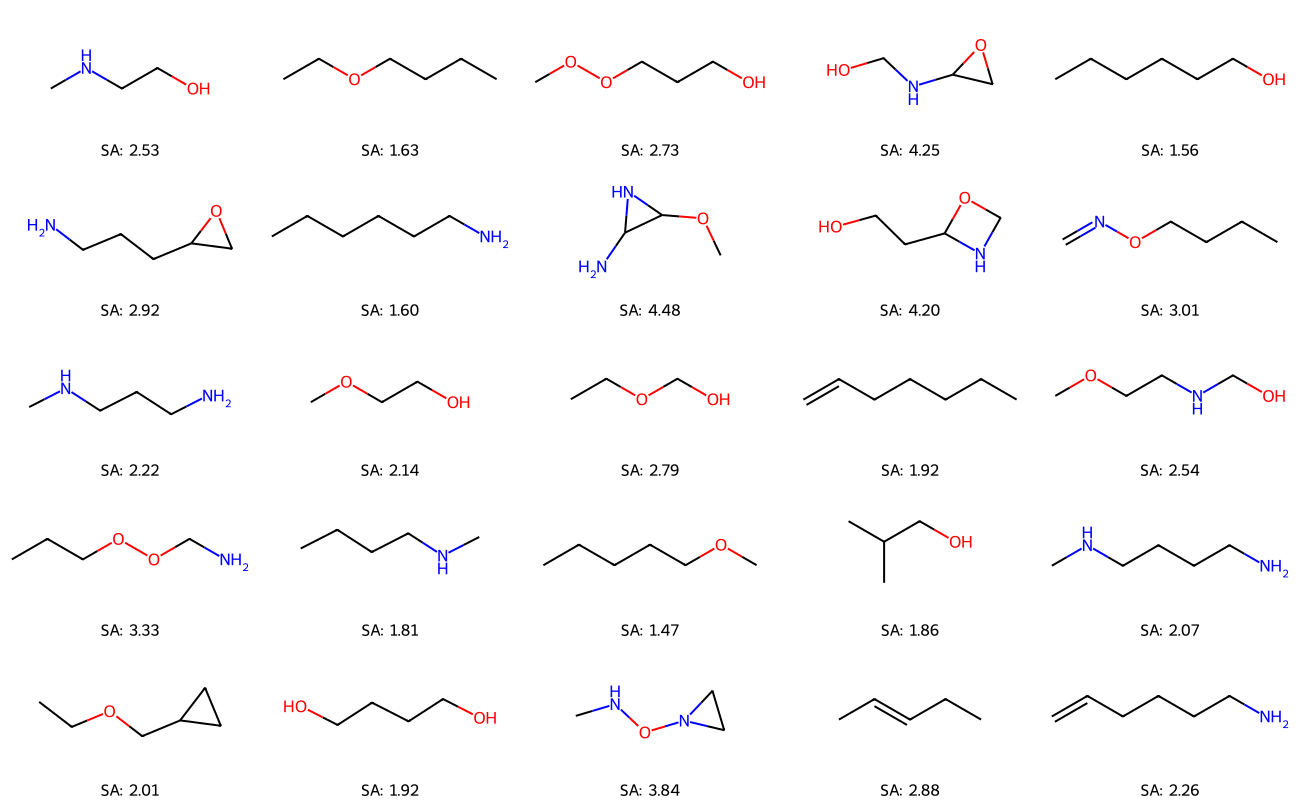

In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, rdMolDescriptors
from rdkit.Chem.rdmolops import GetMolFrags
from rdkit.Chem.Draw import MolsToGridImage
import sascorer  # Make sure to import sascorer

def is_synthesizable(mol, threshold=5.0):
    try:
        sa_score = sascorer.calculateScore(mol)
        return sa_score <= threshold
    except:
        return False

def get_sa_score(mol):
    """Get SA score for a molecule"""
    try:
        return sascorer.calculateScore(mol)
    except:
        return None

def is_normal_alkane(mol):
    if mol is None:
        return False
    mol = Chem.RemoveHs(mol)
    fragments = GetMolFrags(mol, asMols=True)
    if len(fragments) > 1:
        return False
    formula = rdMolDescriptors.CalcMolFormula(mol)
    if not formula.startswith('C') or any(x in formula for x in ['N', 'O', 'Cl', 'Br']):
        return False
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() != 6 or atom.GetHybridization() != Chem.HybridizationType.SP3 or atom.GetDegree() > 4:
            return False
    if mol.GetRingInfo().NumRings() > 0:
        return False
    return True

def is_valid_molecule(mol):
    if mol is None:
        return False
    try:
        Chem.SanitizeMol(mol)
    except:
        return False
    fragments = GetMolFrags(mol, asMols=True)
    if len(fragments) > 1:
        return False
    return True

# Sets to store unique SMILES
unique_smiles = set()
synthesizable_smiles = set()
all_valid_mols = []
mol_sa_scores = []  # Store SA scores corresponding to molecules

# Generate and process molecules
for _ in range(50):
    molecules = model.inference(1000)
    for mol in molecules:
        if mol is None or not is_valid_molecule(mol) or is_normal_alkane(mol):
            continue
        try:
            smiles = Chem.MolToSmiles(mol, canonical=True)
        except:
            continue
        if smiles not in unique_smiles:
            unique_smiles.add(smiles)
            sa_score = get_sa_score(mol)
            if sa_score is not None and is_synthesizable(mol):
                synthesizable_smiles.add(smiles)
                all_valid_mols.append(mol)
                mol_sa_scores.append(sa_score)

# Reporting
total_unique = len(unique_smiles)
total_synthesizable = len(synthesizable_smiles)
print(f"Total unique, valid, non-normal-alkane molecules: {total_unique}")
print(f"Unique synthesizable among them: {total_synthesizable}")
print(f"Synthesizable Unique / Total Unique: {100 * total_synthesizable / total_unique:.2f}%" if total_unique else "No valid molecules.")

# Visualize with SA scores
if all_valid_mols:
    # Create legends with SA scores
    legends = [f"SA: {score:.2f}" for score in mol_sa_scores[:25]]

    # Generate image with SA score labels
    img = MolsToGridImage(
        all_valid_mols[:25],
        molsPerRow=5,
        subImgSize=(260, 160),
        legends=legends
    )

    # Display or save the image
    display(img)  # For Jupyter notebooks
    # img.save('molecules_with_sa_scores.png')  # Uncomment to save to file
else:
    print("No synthesizable molecules found to visualize.")

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


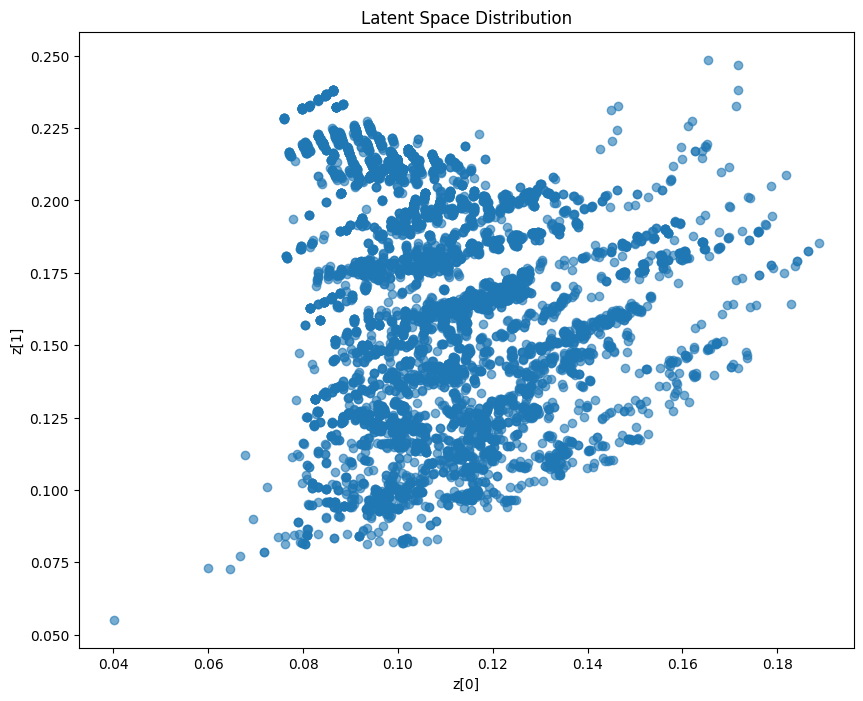

Latent space statistics:
z[0] - mean: 0.111, std: 0.019
z[1] - mean: 0.166, std: 0.037
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


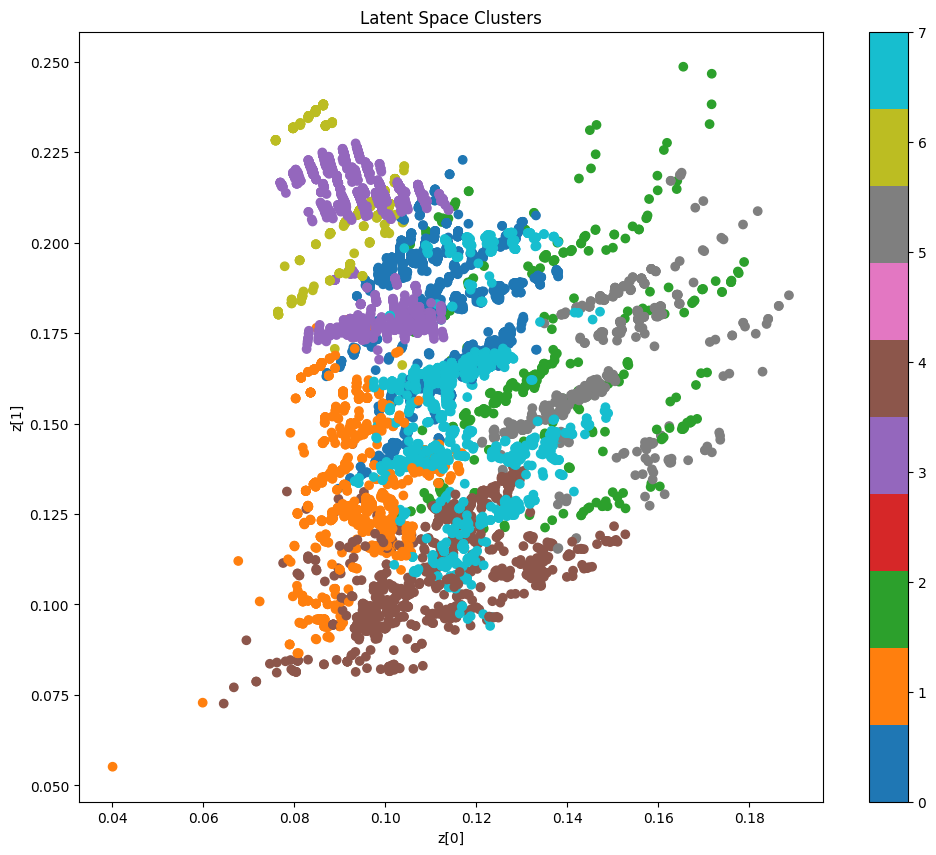

In [ ]:
# Simple visualization
plot_latent_simple(model, [adjacency_tensor[:8000], feature_tensor[:8000]])

# Or with clustering
cluster_labels = plot_latent_clusters(model, [adjacency_tensor[:8000], feature_tensor[:8000]])